### EDA

### Datasets
* Dataset A: a dynamic event graph with entities as nodes and different types of events as edges.
* Dataset B: a user-item graph with users and items as nodes and different types of interactions as edges.
* Train
    * Dataset A
        * edges_train_A.csv
            * src_id -> dst_id, edge_type, timestamp
        * node_features.csv
            * node_id, anonymized categorical features
        * edge_type_features.csv
            * edge_id, anonymized categorical features
    * Dataset B
        * edges_train_B.csv
            * src_id -> dst_id, edge_type, timestamp, feat (anonymized edge features)
* Test
    * Dataset A / Dataset B
        * src_id -> dst_id, edge_type, start_time, end_time


### References
* https://networkx.org/documentation/stable/reference/readwrite/edgelist.html
* https://towardsdatascience.com/pyvis-visualize-interactive-network-graphs-in-python-77e059791f01

In [1]:
import sys
import os
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx

%matplotlib inline

In [2]:
DATA_DIR = "../data/wsdm-2022"

print("FILES")
print(sorted(os.listdir(f"{DATA_DIR}/train")))
print(sorted(os.listdir(f"{DATA_DIR}/test")))

FILES
['edge_type_features.csv', 'edges_train_A.csv', 'edges_train_B.csv', 'node_features.csv']
['input_A.csv', 'input_A_initial.csv', 'input_B.csv', 'input_B_initial.csv']


In [3]:
edge_list = pd.read_csv(
    f"{DATA_DIR}/train/edges_train_A.csv",
    header=None,
    names=['src_id', 'dst_id', 'edge_type', 'timestamp'],
    dtype={'src_id': str, 'dst_id': str, 'edge_type': str, 'timestamp': int},
).sort_values('timestamp')

In [4]:
print(len(edge_list))
edge_list.head()

27045268


,src_id,dst_id,edge_type,timestamp
0,106,28905,96,1413662400
904,28905,5776,33,1413662400
903,28905,5502,69,1413662400
902,28905,5450,237,1413662400
901,28905,3784,15,1413662400


In [5]:
timestamps = edge_list['timestamp'].copy()
datetimes = timestamps.apply(
    lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y%m%d_%H%M%S")
)
dates = timestamps.apply(
    lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y%m%d")
)
edge_list['datetime'] = datetimes
edge_list['date'] = dates
edge_list.head()

,src_id,dst_id,edge_type,timestamp,datetime,date
0,106,28905,96,1413662400,20141019_050000,20141019
904,28905,5776,33,1413662400,20141019_050000,20141019
903,28905,5502,69,1413662400,20141019_050000,20141019
902,28905,5450,237,1413662400,20141019_050000,20141019
901,28905,3784,15,1413662400,20141019_050000,20141019


### Target

In [13]:
target_edge_list = pd.read_csv(
    f"{DATA_DIR}/test/input_A.csv",
    header=None,
    names=['src_id', 'dst_id', 'edge_type', 'start_timestamp', 'end_timestamp'],
    dtype={'src_id': str, 'dst_id': str, 'edge_type': str, 'start_timestamp': int, 'end_timestamp': int},
)#.sort_values('timestamp')
target_edge_list['start_time'] = target_edge_list['start_timestamp'].copy().apply(
    lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y%m%d_%H%M%S")
)
target_edge_list['end_time'] = target_edge_list['end_timestamp'].copy().apply(
    lambda x: datetime.datetime.fromtimestamp(x).strftime("%Y%m%d_%H%M%S")
)
target_edge_list['time_diff'] = target_edge_list['end_timestamp'].copy() - target_edge_list['start_timestamp'].copy()
target_edge_list

,src_id,dst_id,edge_type,start_timestamp,end_timestamp,start_time,end_time,time_diff
0,19,6486,74,1496093495,1496282477,20170530_063135,20170601_110117,188982
1,19,11021,116,1497524067,1497720574,20170615_195427,20170618_022934,196507
2,19,28905,245,1497371665,1497538710,20170614_013425,20170615_235830,167045
3,19,32125,178,1497432877,1497633034,20170614_183437,20170617_021034,200157
4,19,44465,149,1495823478,1495989884,20170527_033118,20170529_014444,166406
...,...,...,...,...,...,...,...,...
49898,69948,28905,238,1494817089,1495000626,20170515_115809,20170517_145706,183537
49899,69948,45285,220,1495740412,1495906305,20170526_042652,20170528_023145,165893
49900,69961,20816,78,1496748482,1496986910,20170606_202802,20170609_144150,238428
49901,69961,33045,20,1497511922,1497656626,20170615_163202,20170617_084346,144704


In [16]:
print(target_edge_list['time_diff'].mean() / 60 / 60 / 24)

1.9989400520342802


### Networks

In [6]:
DG = nx.from_pandas_edgelist(
    edge_list[:200],
    source='src_id', target='dst_id',
    edge_attr=True,
    create_using=nx.DiGraph()
)

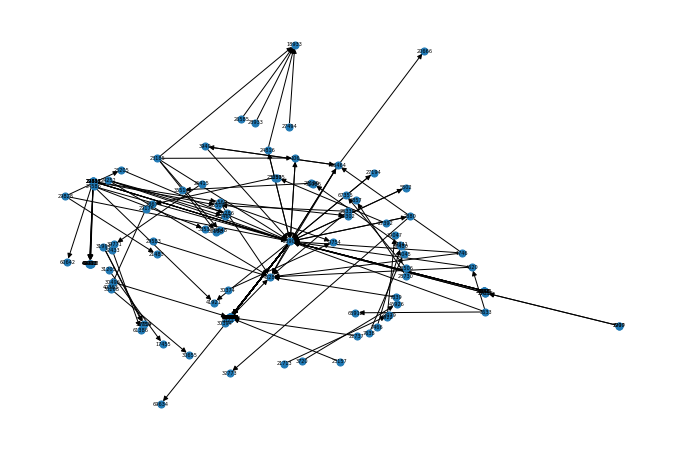

In [7]:
from matplotlib.pyplot import figure, text

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_tight_layout(False)

pos = nx.kamada_kawai_layout(DG)
# pos = nx.spring_layout(DG)
# pos = nx.fruchterman_reingold_layout(G)  # TOO SLOW

nx.draw(
    DG, pos,
    node_size=50,
    # with_labels=True,
)
for node, (x, y) in pos.items():
    text(x, y, node, fontsize=5, ha='center', va='center')

In [8]:
len(edge_list)

27045268

In [9]:
G = nx.from_pandas_edgelist(
    edge_list,
    source='src_id', target='dst_id',
    edge_attr=True,
    create_using=nx.DiGraph()
)

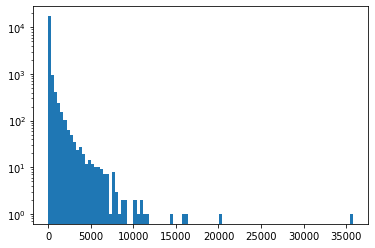

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(
        degrees,
        bins=100,
        log=True,
    )
    plt.show()

plot_degree_dist(G)

In [11]:
from pyvis.network import Network

net = Network()
for index, row in edge_list[:5000].iterrows():
    net.add_node(row['src_id'], label=row['src_id'])
    net.add_node(row['dst_id'], label=row['dst_id'])
    net.add_edge(row['src_id'], row['dst_id'])

In [12]:
# net.show('nodes.html')

<img src="../assets/pyvis_network_2022_0103_01.png">